# AS3.1 - Deep Q-learning Network (Lunar Lander)
<b>Student</b>: Justin Klein<br>
<b>Nummer</b>: 1707815

## Imports

In [1]:
import numpy as np
import gymnasium as gym
from random import randint
from collections import namedtuple
import matplotlib
import matplotlib.pyplot as plt
import torch

from src.dqn import DQN
from src.agent import Agent
from src.policy import Policy
from src.memory import Memory

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


<br>

# Preparation

## Parameters

In [3]:
num_epochs = 1000
max_steps = 2000
avg_reward_threshold = 200

learning_rate = 0.0005
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 10000

memory_size = 10000
sample_size = 32

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

## Creating filler Environment

In [4]:
env = gym.make("LunarLander-v2", render_mode=None)

## Defining Models and Optimizer

In [5]:
filler_neural_net = DQN().to(device)
training_neural_net = DQN().to(device)

print(filler_neural_net)
print(training_neural_net)

DQN(
  (l1): Linear(in_features=8, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=4, bias=True)
)
DQN(
  (l1): Linear(in_features=8, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=4, bias=True)
)


## Defining filler Objects

In [6]:
# Memory class for the Agent
me0 = Memory(memory_size)

# The Policy class for the Agent
p0 = Policy(filler_neural_net, device, env.action_space, epsilon_start, epsilon_end, epsilon_decay)

# The Agent class
a0 = Agent(me0, p0, device, sample_size, num_epochs, max_steps, learning_rate, gamma)

## Defining training Objects

In [7]:
# Memory class for the Agent
me1 = Memory(memory_size)

# The Policy class for the Agent
p1 = Policy(training_neural_net, device, env.action_space, epsilon_start, epsilon_end, epsilon_decay)

# The Agent class
a1 = Agent(me1, p1, device, sample_size, num_epochs, max_steps, learning_rate, gamma)

## Fill memory with some samples

In [8]:
for i in range(10):  # 10 epochs to fill memory
    state = torch.tensor(env.reset(seed=randint(0, 1000))[0], dtype=torch.float32, device=device).unsqueeze(0)
    for step in range(max_steps):
        # ===== Decide action ===== #
        action = a0.policy.select_action(state)

        # ===== Take action, observe result ===== #
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # ===== Store Transition ===== #
        a0.memory.store(state, action, next_state, reward)
        state = next_state

        if terminated or truncated:
            break

env.close()

In [9]:
print(len(a0.memory.deque))
a1.memory.deque = me0.deque.copy()
print(len(a1.memory.deque))

736
736


<br>

## Training

In [10]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

In [11]:
a1.memory.deque = me0.deque.copy()
a1.policy.neural_net.train()

all_epoch_sums = []
run_averages = []
rewards = []
for i in range(1, num_epochs + 1):
    epoch_reward = 0
    state = torch.tensor(env.reset(seed=randint(0, 1000))[0], dtype=torch.float32, device=device).unsqueeze(0)
    for step in range(max_steps):
        # ===== Decide action ===== #
        action = a1.policy.select_action(state)

        # ===== Take action, observe result ===== #
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        epoch_reward += reward.item()

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # ===== Store Transition ===== #
        a1.memory.store(state, action, next_state, reward)
        state = next_state

        # ===== Train the model ===== #
        a1.train()

        if terminated or truncated:
            a1.policy.step_count = 0
            break
    
    all_epoch_sums.append(epoch_reward)
    rewards.append(epoch_reward)

    # ===== Visualization and Model processing ===== #
    print(f"Epoch {i} | Epoch rewards: {epoch_reward} | Epsilon: {a1.policy.epsilon}")

    if i in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
        torch.save(a1.policy.neural_net, f'model_export\LunarLander_{i}.pt')
        
        run_avg_reward = np.mean(rewards)
        run_averages.append(run_avg_reward)
        if run_avg_reward >= 200:
            print(
                f"\nTraining done at Epoch {i} | Average reward: {run_avg_reward} | Epsilon is now: {a1.policy.epsilon}\n")
            rewards = []
            break
        else:
            print(f"\nEpoch {i - 100}-{i} | Average reward: {run_avg_reward} | Epsilon is now: {a1.policy.epsilon}\n")
            rewards = []

env.close()


Epoch 1 | Epoch rewards: -283.16853599682105 | Epsilon: 0.685129782747985
Epoch 2 | Epoch rewards: -366.86522985688083 | Epsilon: 0.2308325988288364
Epoch 3 | Epoch rewards: -565.9072460849204 | Epsilon: 0.013970154231261061
Epoch 4 | Epoch rewards: -157.43715554565392 | Epsilon: 0.01265994366268778
Epoch 5 | Epoch rewards: -110.5576552349722 | Epsilon: 0.012280295279488974
Epoch 6 | Epoch rewards: -170.21336754805264 | Epsilon: 0.011635919355282767
Epoch 7 | Epoch rewards: -8.194052774282568 | Epsilon: 0.010618291619338046
Epoch 8 | Epoch rewards: -201.26584902871622 | Epsilon: 0.010071819801296802
Epoch 9 | Epoch rewards: -284.54834932692006 | Epsilon: 0.01001041826194086
Epoch 10 | Epoch rewards: -306.36757425001167 | Epsilon: 0.010005971870662418
Epoch 11 | Epoch rewards: -161.75104052129873 | Epsilon: 0.010001325725984358
Epoch 12 | Epoch rewards: -498.0301864404334 | Epsilon: 0.010000028202637477
Epoch 13 | Epoch rewards: -370.9875605621688 | Epsilon: 0.01000000777890436
Epoch 14

Epoch 106 | Epoch rewards: -413.66787427123614 | Epsilon: 0.010000000000000009
Epoch 107 | Epoch rewards: -261.6928786375074 | Epsilon: 0.010000000000000009
Epoch 108 | Epoch rewards: -95.75896563467886 | Epsilon: 0.010000000000000009
Epoch 109 | Epoch rewards: -240.89648798442332 | Epsilon: 0.010000000000000009
Epoch 110 | Epoch rewards: -74.1484282439623 | Epsilon: 0.010000000000000009
Epoch 111 | Epoch rewards: -332.71653534366783 | Epsilon: 0.010000000000000009
Epoch 112 | Epoch rewards: -72.14293627987607 | Epsilon: 0.010000000000000009
Epoch 113 | Epoch rewards: -83.70849759855777 | Epsilon: 0.010000000000000009
Epoch 114 | Epoch rewards: -58.96828649956357 | Epsilon: 0.010000000000000009
Epoch 115 | Epoch rewards: -32.14580237682426 | Epsilon: 0.010000000000000009
Epoch 116 | Epoch rewards: -72.10849861709427 | Epsilon: 0.010000000000000009
Epoch 117 | Epoch rewards: -29.440337443649703 | Epsilon: 0.010000000000000009
Epoch 118 | Epoch rewards: -33.5733876907431 | Epsilon: 0.010

Epoch 211 | Epoch rewards: -346.35998502012967 | Epsilon: 0.010000000000000009
Epoch 212 | Epoch rewards: -26.374693698930102 | Epsilon: 0.010000000000000009
Epoch 213 | Epoch rewards: -342.91976076387846 | Epsilon: 0.010000000000000009
Epoch 214 | Epoch rewards: -121.42925000168621 | Epsilon: 0.010000000000000009
Epoch 215 | Epoch rewards: -4.593749965467178 | Epsilon: 0.010000000000000009
Epoch 216 | Epoch rewards: 3.3577997897869274 | Epsilon: 0.010000000000000009
Epoch 217 | Epoch rewards: -48.79934398390779 | Epsilon: 0.010000000000000009
Epoch 218 | Epoch rewards: -78.69239536466584 | Epsilon: 0.010000000000000009
Epoch 219 | Epoch rewards: -33.64874392644303 | Epsilon: 0.010000000000000009
Epoch 220 | Epoch rewards: -51.090270297740396 | Epsilon: 0.010000000000000009
Epoch 221 | Epoch rewards: 0.20044704629475185 | Epsilon: 0.010000000000000009
Epoch 222 | Epoch rewards: -63.07925748806942 | Epsilon: 0.010000000000000009
Epoch 223 | Epoch rewards: -142.25194265240123 | Epsilon: 

Epoch 315 | Epoch rewards: 230.44429739030264 | Epsilon: 0.010000000000000009
Epoch 316 | Epoch rewards: 154.4441107878265 | Epsilon: 0.010000000000000009
Epoch 317 | Epoch rewards: 241.05530041104322 | Epsilon: 0.010000000000000009
Epoch 318 | Epoch rewards: -57.45662726858683 | Epsilon: 0.010000000000000009
Epoch 319 | Epoch rewards: 128.21569519506178 | Epsilon: 0.010000000000000009
Epoch 320 | Epoch rewards: 208.56553093674452 | Epsilon: 0.010000000000000009
Epoch 321 | Epoch rewards: 169.64439148640213 | Epsilon: 0.010000000000000009
Epoch 322 | Epoch rewards: 152.23478585335187 | Epsilon: 0.010000000000000009
Epoch 323 | Epoch rewards: 165.6924717854562 | Epsilon: 0.010000000000000009
Epoch 324 | Epoch rewards: 185.76273183637977 | Epsilon: 0.010000000000000009
Epoch 325 | Epoch rewards: 246.447258795359 | Epsilon: 0.010000000000000009
Epoch 326 | Epoch rewards: -18.063883250420673 | Epsilon: 0.010000000000000009
Epoch 327 | Epoch rewards: -111.72160554495962 | Epsilon: 0.0100000

Epoch 419 | Epoch rewards: 17.924491770886146 | Epsilon: 0.010000000000000009
Epoch 420 | Epoch rewards: 19.57001691943039 | Epsilon: 0.010000000000000009
Epoch 421 | Epoch rewards: -46.20508831910398 | Epsilon: 0.010000000000000009
Epoch 422 | Epoch rewards: -67.09152340011954 | Epsilon: 0.010000000000000009
Epoch 423 | Epoch rewards: -243.1662809103276 | Epsilon: 0.010000000000000009
Epoch 424 | Epoch rewards: -62.39662137245656 | Epsilon: 0.010000000000000009
Epoch 425 | Epoch rewards: -38.08115811850169 | Epsilon: 0.010000000000000009
Epoch 426 | Epoch rewards: 29.223762257189208 | Epsilon: 0.010000000000000009
Epoch 427 | Epoch rewards: -221.76585516119377 | Epsilon: 0.010000000000000009
Epoch 428 | Epoch rewards: -229.42883678725153 | Epsilon: 0.010000000000000009
Epoch 429 | Epoch rewards: 135.54319433266122 | Epsilon: 0.010000000000000009
Epoch 430 | Epoch rewards: -197.78068703076215 | Epsilon: 0.010000000000000009
Epoch 431 | Epoch rewards: -40.737752102347955 | Epsilon: 0.01

Epoch 523 | Epoch rewards: 250.45790029061874 | Epsilon: 0.010000000000000009
Epoch 524 | Epoch rewards: 240.54400887145073 | Epsilon: 0.010000000000000009
Epoch 525 | Epoch rewards: 202.52835625515405 | Epsilon: 0.010000000000000009
Epoch 526 | Epoch rewards: 250.41574484690324 | Epsilon: 0.010000000000000009
Epoch 527 | Epoch rewards: 188.64099515477116 | Epsilon: 0.010000000000000009
Epoch 528 | Epoch rewards: 0.5579532377148979 | Epsilon: 0.010000000000000009
Epoch 529 | Epoch rewards: -88.00036292358311 | Epsilon: 0.010000000000000009
Epoch 530 | Epoch rewards: -56.906379294142795 | Epsilon: 0.010000000000000009
Epoch 531 | Epoch rewards: 276.17875476851714 | Epsilon: 0.010000000000000009
Epoch 532 | Epoch rewards: 290.431676238941 | Epsilon: 0.010000000000000009
Epoch 533 | Epoch rewards: 52.17254140009308 | Epsilon: 0.010000000000000009
Epoch 534 | Epoch rewards: 216.91084867349326 | Epsilon: 0.010000000000000009
Epoch 535 | Epoch rewards: 173.09917821014534 | Epsilon: 0.0100000

Epoch 628 | Epoch rewards: -415.86032570564373 | Epsilon: 0.010000000000000009
Epoch 629 | Epoch rewards: 170.76561129388637 | Epsilon: 0.010000000000000009
Epoch 630 | Epoch rewards: -26.17104364296388 | Epsilon: 0.010000000000000009
Epoch 631 | Epoch rewards: 236.67153303896538 | Epsilon: 0.010000000000000009
Epoch 632 | Epoch rewards: 236.566993078235 | Epsilon: 0.010000000000000009
Epoch 633 | Epoch rewards: 242.7237904018545 | Epsilon: 0.010000000000000009
Epoch 634 | Epoch rewards: 45.24400233266451 | Epsilon: 0.010000000000000009
Epoch 635 | Epoch rewards: 204.3147583681105 | Epsilon: 0.010000000000000009
Epoch 636 | Epoch rewards: 171.29446022404696 | Epsilon: 0.010000000000000009
Epoch 637 | Epoch rewards: 241.77999431462518 | Epsilon: 0.010000000000000009
Epoch 638 | Epoch rewards: 252.62160395256703 | Epsilon: 0.010000000000000009
Epoch 639 | Epoch rewards: 283.430369398648 | Epsilon: 0.010000000000000009
Epoch 640 | Epoch rewards: 261.9260351603569 | Epsilon: 0.010000000000

Epoch 733 | Epoch rewards: 249.9241752363512 | Epsilon: 0.010000000000000009
Epoch 734 | Epoch rewards: 227.23606824201278 | Epsilon: 0.010000000000000009
Epoch 735 | Epoch rewards: 210.40180052225594 | Epsilon: 0.010000000000000009
Epoch 736 | Epoch rewards: 233.21811791562487 | Epsilon: 0.010000000000000009
Epoch 737 | Epoch rewards: 289.8201092071045 | Epsilon: 0.010000000000000009
Epoch 738 | Epoch rewards: 279.70340260868045 | Epsilon: 0.010000000000000009
Epoch 739 | Epoch rewards: 279.285230487693 | Epsilon: 0.010000000000000009
Epoch 740 | Epoch rewards: 280.1452281831057 | Epsilon: 0.010000000000000009
Epoch 741 | Epoch rewards: 199.32517184326446 | Epsilon: 0.010000000000000009
Epoch 742 | Epoch rewards: 231.913768205303 | Epsilon: 0.010000000000000009
Epoch 743 | Epoch rewards: 211.25478855063506 | Epsilon: 0.010000000000000009
Epoch 744 | Epoch rewards: 204.27942633894526 | Epsilon: 0.010000000000000009
Epoch 745 | Epoch rewards: 239.42302736548655 | Epsilon: 0.010000000000

Epoch 838 | Epoch rewards: 230.06507577995322 | Epsilon: 0.010000000000000009
Epoch 839 | Epoch rewards: 11.555463819517541 | Epsilon: 0.010000000000000009
Epoch 840 | Epoch rewards: 244.42603861644915 | Epsilon: 0.010000000000000009
Epoch 841 | Epoch rewards: 295.9333986137219 | Epsilon: 0.010000000000000009
Epoch 842 | Epoch rewards: 256.3739318203247 | Epsilon: 0.010000000000000009
Epoch 843 | Epoch rewards: 213.02527582026028 | Epsilon: 0.010000000000000009
Epoch 844 | Epoch rewards: 178.487505521135 | Epsilon: 0.010000000000000009
Epoch 845 | Epoch rewards: 207.21614310494175 | Epsilon: 0.010000000000000009
Epoch 846 | Epoch rewards: 271.8002665743565 | Epsilon: 0.010000000000000009
Epoch 847 | Epoch rewards: 273.9644936062057 | Epsilon: 0.010000000000000009
Epoch 848 | Epoch rewards: -16.741439457365658 | Epsilon: 0.010000000000000009
Epoch 849 | Epoch rewards: 263.92875579110614 | Epsilon: 0.010000000000000009
Epoch 850 | Epoch rewards: 205.02391324072758 | Epsilon: 0.0100000000

Epoch 943 | Epoch rewards: 238.54387355402224 | Epsilon: 0.010000000000000009
Epoch 944 | Epoch rewards: 232.33150007596385 | Epsilon: 0.010000000000000009
Epoch 945 | Epoch rewards: 263.9323134723992 | Epsilon: 0.010000000000000009
Epoch 946 | Epoch rewards: 225.71696137984804 | Epsilon: 0.010000000000000009
Epoch 947 | Epoch rewards: 290.11644554033137 | Epsilon: 0.010000000000000009
Epoch 948 | Epoch rewards: 206.71972360392053 | Epsilon: 0.010000000000000009
Epoch 949 | Epoch rewards: 231.37220125054182 | Epsilon: 0.010000000000000009
Epoch 950 | Epoch rewards: 228.97584747894416 | Epsilon: 0.010000000000000009
Epoch 951 | Epoch rewards: 275.1334374530286 | Epsilon: 0.010000000000000009
Epoch 952 | Epoch rewards: 222.00545427545862 | Epsilon: 0.010000000000000009
Epoch 953 | Epoch rewards: 291.6308666061703 | Epsilon: 0.010000000000000009
Epoch 954 | Epoch rewards: -85.83497704882879 | Epsilon: 0.010000000000000009
Epoch 955 | Epoch rewards: 254.38905318328577 | Epsilon: 0.01000000

## Visualization

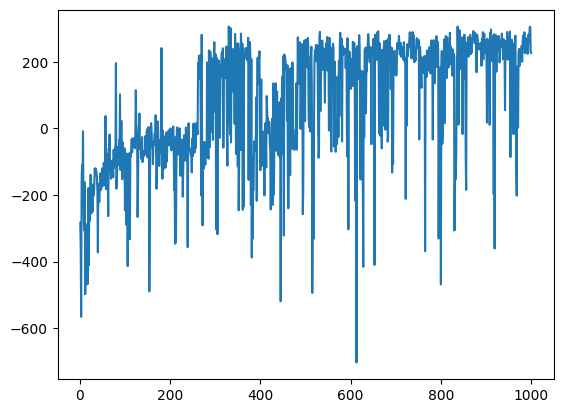

In [12]:
# ===== Visualizing the rewards per epoch ===== #
x_axis = [i for i in range(1, len(all_epoch_sums)+1)]
plt.plot(x_axis, all_epoch_sums)
plt.show()

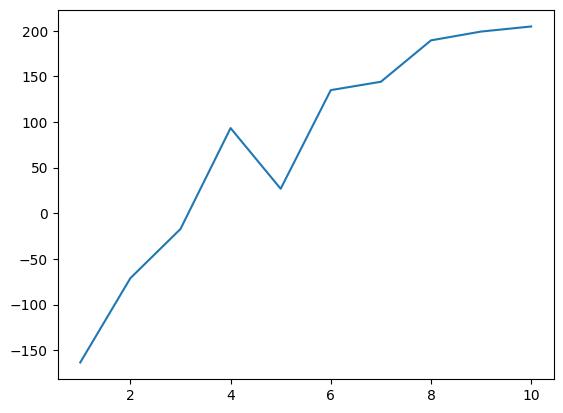

In [13]:
# ===== Visualizing the average running rewards between 100-200-300 epochs, etc. ===== #
x_axis = [i for i in range(1, len(run_averages)+1)]
plt.plot(x_axis, run_averages)
plt.show()

# Loading and testing the model

In [4]:
env = gym.make("LunarLander-v2", render_mode="human")

In [5]:
model = torch.load('model_export/LunarLander_1000.pt')

In [ ]:
# try:
all_epoch_sums = []
run_averages = []
rewards = []
for i in range(1, 10 + 1):
    epoch_reward = 0
    state = torch.tensor(env.reset(seed=randint(0, 1000))[0], dtype=torch.float32, device=device).unsqueeze(0)
    for step in range(2000):
        # ===== Decide action ===== #
        action = torch.tensor([model(state).argmax()], dtype=torch.int64, device=device)

        # ===== Take action, observe result ===== #
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        epoch_reward += reward.item()

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        state = next_state

        if terminated or truncated:
            break

    all_epoch_sums.append(epoch_reward)
    rewards.append(epoch_reward)

    # ===== Visualization and Model processing ===== #
    print(f"Epoch {i} | Epoch rewards: {epoch_reward}")

env.close()
        
# except:
#     env.close()

Epoch 1 | Epoch rewards: 268.2015404803251
Epoch 2 | Epoch rewards: 267.0111550967881
Epoch 3 | Epoch rewards: 280.8238446671014
Epoch 4 | Epoch rewards: 293.4637692091466
Epoch 5 | Epoch rewards: 251.68814519345963
Epoch 6 | Epoch rewards: 261.91774325443174
